# Lung Cancer EDA and Modeling

## 0. Dataset Overview

Number of Instances: patient-level records (rows)

Number of Attributes: 15 predictive attributes and 1 target class

Attribute Information:
- age: age of patient at time of diagnosis
- gender: male/female
- country: country where patient resides at time of diagnosis
- diagnosis_date: date of patients diagnosis (year-month-day)
- cancer_stage: stage of cancer at time of diagnosis (1,2,3,4)
- family_history: yes/no of a family history of cancer
- smoking_status: smoking status of patient (1: current smoker, 2: former smoker, 3: never smoked, 4: passive smoker)
- bmi: Body Mass Index of patient at time of diagnosis
- cholesterol_level: integer value of cholesterol_level
- hypertension: indicates if patient has high blood pressure (1: yes, 0: no)
- asthma: indicates if patient has asthma (1: yes, 0: no)
- cirrhosis: indicates if patient has cirrhosis (1: yes, 0: no)
- other_cancer: indicates if patient has another form of cancer, aside from original diagnosis (1: yes, 0: no)
- treatment_type: type of treatment patient received (1: surgery, 2: chemotherapy, 3: radiation, 4: combined)
- end_treatment_date: date on which patient completed their treatment or died
- survived (target): indicates if patient lived or died (1: yes, 0:no)


class:
- survived = 1: patient who survived cancer treatment 
- survived = 0: patient who died during cancer treatment (due to cancer)

## 1. Environment Setup

In [ ]:
#Setup

from pathlib import Path
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, kendalltau, chi2_contingency, ttest_ind, mannwhitneyu
from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from IPython.display import display, Markdown
import opendatasets as od 
import seaborn as sns
from itertools import combinations 
from yellowbrick.features import Rank2D

#Scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, Lasso, LogisticRegressionCV
from sklearn.dummy import DummyClassifier
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.feature_selection import VarianceThreshold
from sklearn.base import clone
from sklearn.metrics import (
    roc_auc_score,           #Measures how well the model separates classes (higher is better)
    average_precision_score, #Average precision for PR curves (good for imbalance)
    brier_score_loss,        #Mean squared error of predicted probabilities (lower is better)
    log_loss,                #Penalizes bad probability estimates (lower is better)
    confusion_matrix,        #Counts TP/FP/TN/FN
    precision_score,         #Of predicted positives, how many were correct?
    recall_score,            #Of actual positives, how many did we catch?
    RocCurveDisplay,         
    PrecisionRecallDisplay,
    f1_score,
    r2_score, 
    mean_squared_error,
    classification_report
)
#Fairness utilities
try:
    from fairlearn.metrics import (
        MetricFrame,
        selection_rate,
        true_positive_rate,
        false_positive_rate,
    )
    _FAIRLEARN = True
except Exception:
    _FAIRLEARN = False

#Responsible AI dashboard
try:
    from responsibleai import RAIInsights
    from raiwidgets import ResponsibleAIDashboard
    _RAI = True
except Exception:
    _RAI = False

#Course utilities for transparency and thresholding
from utils import (
    positive_scores,
    auc_report,
    tradeoff_table,
    pick_threshold_cost,
    pick_threshold_recall_floor,
    pick_threshold_workload,
    summary_at_threshold,
    plot_recall_floor_curves,
    plot_cumulative_recall_at_threshold,
    plot_topk_at_threshold,
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


## 2. Data Loading and Preparation

In [ ]:
#Path to the CSV on your machine
DATA_PATH = "./Data/lung_cancer_dataset_med.csv"

df_raw = pd.read_csv(DATA_PATH)
print("Shape:", df_raw.shape)
df_raw.head(15)

Shape: (890000, 17)


,id,age,gender,country,diagnosis_date,cancer_stage,family_history,smoking_status,bmi,cholesterol_level,hypertension,asthma,cirrhosis,other_cancer,treatment_type,end_treatment_date,survived
0,1,64.0,Male,Sweden,2016-04-05,Stage I,Yes,Passive Smoker,29.4,199,0,0,1,0,Chemotherapy,2017-09-10,0
1,2,50.0,Female,Netherlands,2023-04-20,Stage III,Yes,Passive Smoker,41.2,280,1,1,0,0,Surgery,2024-06-17,1
2,3,65.0,Female,Hungary,2023-04-05,Stage III,Yes,Former Smoker,44.0,268,1,1,0,0,Combined,2024-04-09,0
3,4,51.0,Female,Belgium,2016-02-05,Stage I,No,Passive Smoker,43.0,241,1,1,0,0,Chemotherapy,2017-04-23,0
4,5,37.0,Male,Luxembourg,2023-11-29,Stage I,No,Passive Smoker,19.7,178,0,0,0,0,Combined,2025-01-08,0
5,6,50.0,Male,Italy,2023-01-02,Stage I,No,Never Smoked,37.6,274,1,0,0,0,Radiation,2024-12-27,0
6,7,49.0,Female,Croatia,2018-05-21,Stage III,Yes,Passive Smoker,43.1,259,0,0,0,0,Radiation,2019-05-06,1
7,8,51.0,Male,Denmark,2017-02-18,Stage IV,Yes,Former Smoker,25.8,195,1,1,0,0,Combined,2017-08-26,0
8,9,64.0,Male,Sweden,2021-03-21,Stage III,Yes,Current Smoker,21.5,236,0,0,0,0,Chemotherapy,2022-03-07,0
9,10,56.0,Male,Hungary,2021-11-30,Stage IV,Yes,Current Smoker,17.3,183,1,0,0,1,Surgery,2023-11-29,0


### 2.1 Basic Cleaning and Schema Alignment

In [ ]:
#The outcome prevalence and missingness
TARGET = "survived"  #target: 1 = survived, 0 = died

#Creating a copy of the raw DataFrame
df = df_raw.copy()

#Standardizing column names
df.columns = [c.strip().replace(" ", "_").replace("-", "_")
              for c in df.columns]

#Drop ID column
if df.shape[1] > 0:
    df = df.drop(columns=[df.columns[0]])


#Helper to change various binary encodings to 0/1
def to_binary(s: pd.Series) -> pd.Series:
    if s.dtype == "O":
        mapped = s.astype(str).str.strip().str.lower().map({
            "1": 1, "0": 0,
            "y": 1, "n": 0,
            "yes": 1, "no": 0,
            "true": 1, "false": 0,
            "male":1, "female":0
        })
        s = pd.to_numeric(mapped, errors="coerce")
    else:
        s = pd.to_numeric(s, errors="coerce")
    return (s.fillna(0) > 0).astype(int)


def to_date(dt: pd.Series) -> pd.Series: 
    return pd.to_datetime(dt, errors='coerce')
   
#ensure conversion to binary 
binary_cols = ['gender', 'family_history', 'hypertension', 'asthma', 'cirrhosis', 'other_cancer']
for col in binary_cols:
    df[col] = to_binary(df[col])
    print(f"{col} done")

#conversion to datetime
df["diagnosis_date"] = to_date(df["diagnosis_date"])
df["end_treatment_date"] = to_date(df["end_treatment_date"])

#one hot encoding for necessary columns
cat_cols = ['smoking_status', 'treatment_type']      #categorical columns
df = pd.get_dummies(df, columns=cat_cols, drop_first=False)

#ordinal encoding for cancer_stage
stage_map = {
    "Stage I": 1,
    "Stage II": 2,
    "Stage III": 3,
    "Stage IV": 4
}
df["cancer_stage"] = df["cancer_stage"].map(stage_map)


#for better readability
rename_dict = {
    'smoking_status_Current Smoker': 'smoker_current',
    'smoking_status_Former Smoker': 'smoker_former',
    'smoking_status_Never Smoked': 'smoker_never',
    'smoking_status_Passive Smoker': 'smoker_passive',
    'treatment_type_Chemotherapy': 'treat_chemo',
    'treatment_type_Combined': 'treat_combined',
    'treatment_type_Radiation': 'treat_radiation',
    'treatment_type_Surgery': 'treat_surgery'
}
df.rename(columns=rename_dict, inplace=True)



gender done
family_history done
hypertension done
asthma done
cirrhosis done
other_cancer done


In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 890000 entries, 0 to 889999
Data columns (total 22 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   age                 890000 non-null  float64       
 1   gender              890000 non-null  int32         
 2   country             890000 non-null  object        
 3   diagnosis_date      890000 non-null  datetime64[ns]
 4   cancer_stage        890000 non-null  int64         
 5   family_history      890000 non-null  int32         
 6   bmi                 890000 non-null  float64       
 7   cholesterol_level   890000 non-null  int64         
 8   hypertension        890000 non-null  int32         
 9   asthma              890000 non-null  int32         
 10  cirrhosis           890000 non-null  int32         
 11  other_cancer        890000 non-null  int32         
 12  end_treatment_date  890000 non-null  datetime64[ns]
 13  survived            890000 no

## 3. Exploratory Data Analysis

In [94]:
print(df.shape)
print(f"\n{df.info()} \n\n")

df.describe().T

(890000, 22)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 890000 entries, 0 to 889999
Data columns (total 22 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   age                 890000 non-null  float64       
 1   gender              890000 non-null  int32         
 2   country             890000 non-null  object        
 3   diagnosis_date      890000 non-null  datetime64[ns]
 4   cancer_stage        890000 non-null  int64         
 5   family_history      890000 non-null  int32         
 6   bmi                 890000 non-null  float64       
 7   cholesterol_level   890000 non-null  int64         
 8   hypertension        890000 non-null  int32         
 9   asthma              890000 non-null  int32         
 10  cirrhosis           890000 non-null  int32         
 11  other_cancer        890000 non-null  int32         
 12  end_treatment_date  890000 non-null  datetime64[ns]
 13  survived        

,count,mean,std,min,25%,50%,75%,max
age,890000.0,55.007008,9.994485,4.0,48.0,55.0,62.0,104.0
gender,890000.0,0.500151,0.500000,0.0,0.0,1.0,1.0,1.0
cancer_stage,890000.0,2.500148,1.118078,1.0,1.0,3.0,4.0,4.0
family_history,890000.0,0.499797,0.500000,0.0,0.0,0.0,1.0,1.0
bmi,890000.0,30.494172,8.368539,16.0,23.3,30.5,37.7,45.0
cholesterol_level,890000.0,233.633916,43.432278,150.0,196.0,242.0,271.0,300.0
hypertension,890000.0,0.750024,0.432999,0.0,1.0,1.0,1.0,1.0
asthma,890000.0,0.469740,0.499084,0.0,0.0,0.0,1.0,1.0
cirrhosis,890000.0,0.225956,0.418211,0.0,0.0,0.0,0.0,1.0
other_cancer,890000.0,0.088157,0.283524,0.0,0.0,0.0,0.0,1.0


### 3.0 Country Distribution

In [ ]:
print(df['country'].nunique())
print(df['country'].unique())
#print(df['country'].value_counts())

### 3.1 Target Distribution

196004/890000 patients survived lung cancer, which is ~22.02% (barely 1/5th) of patients logged in this dataset. 

For our next steps, this distribution of the classes (extremely unbalanced) means we will need to correct our imbalance through resampling strategies by either oversampling (SMOTE) or undersampling non-survivors in order to balance (but this would result in informaiton loss, so best not). Depending on the future model used, we could also explore adjusting class weights and ensure we are utilizing specific metrics (f1, roc, recall). 

Outcome counts:
0    693996
1    196004
Name: survived, dtype: int64

Prevalence: 22.02%
Patients who survived per 1000: 220.2




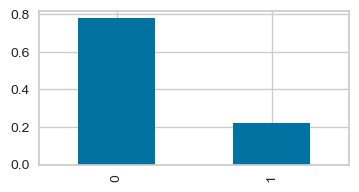

In [ ]:
#Outcome prevalence
counts = df_raw[TARGET].value_counts(dropna=False)
prevalence_percent = counts[1] / counts.sum() * 100
positives_per_1000 = counts[1] / counts.sum() * 1000

print("Outcome counts:")
print(counts)
print(f"\nPrevalence: {prevalence_percent:.2f}%")
print(f"Patients who survived per 1000: {positives_per_1000:.1f}\n\n") 

plt.figure(figsize=(4,2))
df['survived'].value_counts(normalize=True).plot(kind='bar');


In [96]:
df_female = df[df['gender'] == 0]
df_male = df[df['gender']== 1]
print(df_female.shape)
print(df_male.shape)


(444866, 22)
(445134, 22)


### 3.2 Univariate Analysis

#### 3.2.1 Continuous Variables

**Age**

Most of our patients are wihtin 48-62 years old (25-75%), with the average patient being 55.0. The youngest patient is 4 and the oldest was 104, meaning this data is likely very skewed as the majority of the patients are within 40-75 years but there are a few extreme outliers. This indicates that the presence of younger patients are rare and can point to data anomalies. 

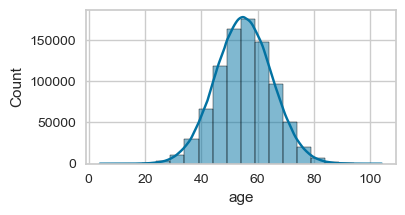

In [97]:
plt.figure(figsize=(4,2))
sns.histplot(df['age'], bins=20, kde=True);
plt.show()

**Female/Male Age**

The means and medians are nearly identical, around ~55 years, along with the distributions spread (within 48-62 range) and the quartiles. The extremes/outliers are barely different, with female 7-104 and male 4-101, which are all outliers. This indicates that age between the genders will do little to explain survival outcomes. 

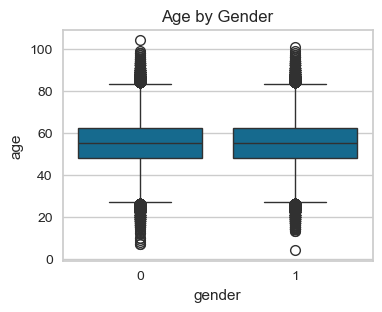

Female Age: 
count    444866.000000
mean         55.016457
std           9.996612
min           7.000000
25%          48.000000
50%          55.000000
75%          62.000000
max         104.000000
Name: age, dtype: float64

Male Age: 
count    445134.000000
mean         54.997565
std           9.992360
min           4.000000
25%          48.000000
50%          55.000000
75%          62.000000
max         101.000000
Name: age, dtype: float64


In [98]:
plt.figure(figsize=(4,3))
sns.boxplot(x='gender', y='age', data=df); 
plt.title('Age by Gender')
plt.show()


print(f"Female Age: \n{df_female['age'].describe()}\n")
print(f"Male Age: \n{df_male['age'].describe()}")

**BMI**

The BMI of most patients is 23-37.7 (25-75%), with the average BMI being 30.4. The lower score is 16 while the higest score is 45. This data is more concentrated, with the average patient being overweight to obese, but this is to be expected as the range itself is normally within 18.5-40 (from underweight to class 3 obesity). A higher BMI is also an indicator of other risks, such as hypertension or diabetes, which would worsed the lung cancer prognosis. 

A more in depth analysis of BMI for women vs men should be done, as these values will signify different levels of BMI in different genders.

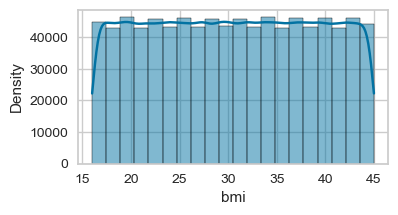

In [99]:
plt.figure(figsize=(4,2))
plt.ylabel('Density')
sns.histplot(df['bmi'], bins=20, kde=True);
plt.show() 

**Female/Male BMI**

The means and medians for both genders are nearly identical (~30.5), so overall the distributions (including the spread, quartiles) for BMI are nearly the same. This still indicates that regardless of gender, patients are overweight to obese. There is no strong gender difference when it comes to BMI, so this will not assist with explain gender specific survival differences.  

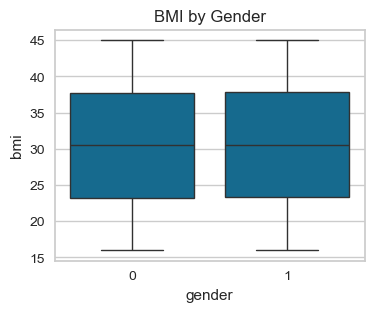

Female BMI: 
count    444866.000000
mean         30.489951
std           8.369305
min          16.000000
25%          23.200000
50%          30.500000
75%          37.700000
max          45.000000
Name: bmi, dtype: float64

Male BMI: 
count    445134.000000
mean         30.498389
std           8.367781
min          16.000000
25%          23.300000
50%          30.500000
75%          37.800000
max          45.000000
Name: bmi, dtype: float64


In [100]:
plt.figure(figsize=(4,3))
sns.boxplot(x='gender', y='bmi', data=df); 
plt.title('BMI by Gender')
plt.show()


print(f"Female BMI: \n{df_female['bmi'].describe()}\n")
print(f"Male BMI: \n{df_male['bmi'].describe()}")

**Cholesterol Level**

The cholesterol levels of patients is within 196-271% (25-75%), with the average level being 233.63. This data reveals that the average person diagnosed with lung cancer has above average cholesterol levels, as a desirable level is less than 200mg/dL and high levels are 200-239 mg/dL -- yet the majority of our patient pool is between 196-271 (highest being 300 and lowest being 150), signifying there could be a correlation between high cholesterol and a lung cancer diagnosis. 

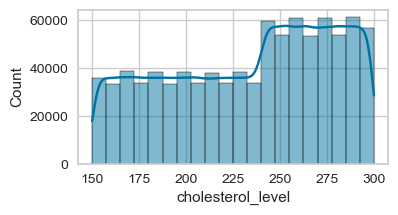

In [101]:
plt.figure(figsize=(4,2))
sns.histplot(df['cholesterol_level'], bins=20, kde=True);
plt.show() 

**Female/Male Cholesterol**

Once again, medians (242) and means (~233.6) are nearly identical between the genders, along with the spread (std=43), quartiles (196-271 mg/dL, with some extremes from 150-300). This indicates that again, regardless of gender, most patients are above the recommended level. 

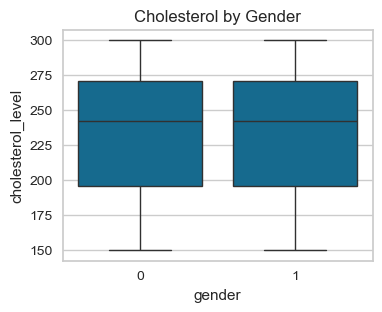

Female Cholesterol: 
count    444866.000000
mean        233.624183
std          43.445918
min         150.000000
25%         196.000000
50%         242.000000
75%         271.000000
max         300.000000
Name: cholesterol_level, dtype: float64

Male Cholesterol: 
count    445134.000000
mean        233.643642
std          43.418688
min         150.000000
25%         196.000000
50%         242.000000
75%         271.000000
max         300.000000
Name: cholesterol_level, dtype: float64


In [102]:
plt.figure(figsize=(4,3))
sns.boxplot(x='gender', y='cholesterol_level', data=df); 
plt.title('Cholesterol by Gender')
plt.show()


print(f"Female Cholesterol: \n{df_female['cholesterol_level'].describe()}\n")
print(f"Male Cholesterol: \n{df_male['cholesterol_level'].describe()}")

#### 3.2.2 Binary Variables


This graph reveals the prevelance of 1's (yes's) within our data set for hypertension, family history (of cancer), asthma, cirrhosis, survived, and other cancers (being detected ontop of lung cancer). We will discuss gender and survived, seperately.

**Hypertension**

667521 out of 890000 (75%) of patients diagnosed with lung cancer also had hypertension (high blood pressure), which is another serious health issue. This typically follows a life of bad diets, minimal exersise, or simply genetics/age. This much higher than hypertension prevelance in Europe (30-45% of adults), which is consistent with lung cancer patients being older with other risk factors. This reinforces that cardiovascular risks are more common in lung cancer patients in Europe. 

**Family History**

444819 out of 890000 (49.97%) of patients had a existing family history of cancer. This is still quite high, indicating genetic predispositions (and potentially better record keeping of medical records within healthcare systems/family records, which can vary from region to region). 

**Asthma**

418069 out of 890000 (46.97%) of patients had a diagnosis of asthma (another lung/breathing disorder). This is much higher than the overall prevelance of asthma in Europe, which is only 5-10% of the general population. This shows a strong correlation between chronic respiratory conditions and a risk of lung cancer. It could also be likely that patients already diagnosed with asthma were already getting more frequent checkups, allowing for the detection of lung cancer to be more likely. 

**Cirrhosis**

201101 our of 890000 (22.59%) of patients have cirrhosis, which is a condition that scars and damages the liver (leads to hypertension, blocks ability to filter toxisn/process nutrients/produce bile/etc.). Considering Europe, especially central/eastern regions, are already facing some of the highest cirrhosis rates globally due to alcohol consumption, this follows the same track that LC patients would also face an increased likelihood of a diagnosis. This is also very clinically significant as cirrhosis will reduce tolerance to chemotheray. 

**Other Cancer** 
78460 out of 890000 (8.81%) of patients had another diagnosis for cancer (ontop of lung cancer). Considering Europe has an ageing population and a high long-term smoking population, indicating cancer rates will increase in likelihood. 


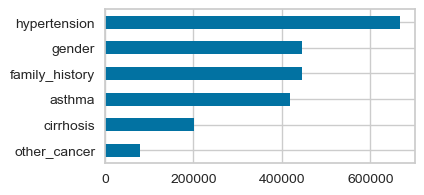

In [103]:
plt.figure(figsize=(4,2))
df[binary_cols].sum().sort_values().plot(kind='barh');
plt.show()

In [104]:
for col in binary_cols:
    if col == "gender" or col == "survived":
        continue
    else:
        counts = df_raw[col].value_counts(dropna=False)
        prevalence_percent = counts[1] / counts.sum() * 100
        positives_per_1000 = counts[1] / counts.sum() * 1000
        print(f"{col}: \n{counts}\nPrevalence %: {prevalence_percent}\nPositives per 1000: {positives_per_1000}\n\n")


family_history: 
No     445181
Yes    444819
Name: family_history, dtype: int64
Prevalence %: 49.979662921348314
Positives per 1000: 499.7966292134832


hypertension: 
1    667521
0    222479
Name: hypertension, dtype: int64
Prevalence %: 75.00235955056179
Positives per 1000: 750.0235955056179


asthma: 
0    471931
1    418069
Name: asthma, dtype: int64
Prevalence %: 46.974044943820225
Positives per 1000: 469.74044943820223


cirrhosis: 
0    688899
1    201101
Name: cirrhosis, dtype: int64
Prevalence %: 22.59561797752809
Positives per 1000: 225.9561797752809


other_cancer: 
0    811540
1     78460
Name: other_cancer, dtype: int64
Prevalence %: 8.815730337078652
Positives per 1000: 88.15730337078652




#### 3.2.3 Categorical Variables

**Smoking Status**

The dataset split almost evenly in 4 for passive smoking (25.07%), never smoked (25.02%), former smoker (24.96%), and current smoker (24.93%). 

**Treatment Type** 

The same goes for treatment type, with chemotherapy (25.08%), surgery (25.08%), combined (25.01%), and radiation (24.81%). 

In [105]:
for col in ['smoking_status', 'treatment_type']:
    counts = df_raw[col].value_counts(dropna=False)
    prevalence_percent = (counts / counts.sum()) * 100
    positives_per_1000 = (counts / counts.sum()) * 1000
    print(f"{col}:\n{counts}\n\nPrevalence %:\n{prevalence_percent}\n\nPositives per 1000:\n{positives_per_1000}\n\n")


smoking_status:
Passive Smoker    223170
Never Smoked      222751
Former Smoker     222181
Current Smoker    221898
Name: smoking_status, dtype: int64

Prevalence %:
Passive Smoker    25.075281
Never Smoked      25.028202
Former Smoker     24.964157
Current Smoker    24.932360
Name: smoking_status, dtype: float64

Positives per 1000:
Passive Smoker    250.752809
Never Smoked      250.282022
Former Smoker     249.641573
Current Smoker    249.323596
Name: smoking_status, dtype: float64


treatment_type:
Chemotherapy    223262
Surgery         223261
Combined        222609
Radiation       220868
Name: treatment_type, dtype: int64

Prevalence %:
Chemotherapy    25.085618
Surgery         25.085506
Combined        25.012247
Radiation       24.816629
Name: treatment_type, dtype: float64

Positives per 1000:
Chemotherapy    250.856180
Surgery         250.855056
Combined        250.122472
Radiation       248.166292
Name: treatment_type, dtype: float64




### 3.3 Bivariate Analysis

#### 3.3.1 Continuous vs Target

**Here we are asking if survivors have different average values than the non suvivors.**

To analyze any influence from the continuous variables on the target feature, we will be 
- Analyzing summary stats between the distribution of continuous variables between survivors and non-survivors. 
- Visualizing them through box plots to see the distributional differences
- Performings statistical tests: t-test (compares means, assumes equal variance/normality) and mann whitney tests (non parametric, tests distribution shift)
- Performing Cohen's d to determine effect size for mean differences 

**Survival vs Age**

There appears to be minimal relationship between age and survival rates, as the means are both ~55.0 and the both of the medians are 55.0, along with the quartiles (middle 50%) both being 42-62 years, which aligns with lung cancer being more commonafter 45. The one difference is the non-survivor gropu had patients as young as 4 and as old as 104, while the survivor group was within the range of 10-101 years. 

In the statistical tests below, the mean age differs by around ~0.03 years (essentially no difference), the t-test p=0.244 and mann-whitney u test p= 0.141 (both >0.05) show no statistically different difference, and the cohen's d= 0.003 shows a negligable effective size. Again, it is proven that survivors/non-survivors are essentially the same age on avergae. 

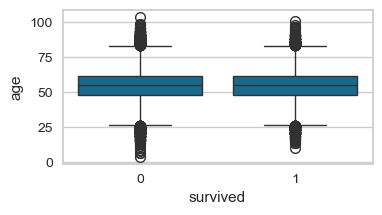

In [106]:
plt.figure(figsize=(4,2))
sns.boxplot(x='survived', y='age', data=df);
plt.show()

In [107]:
print(df.groupby('survived')['age'].describe())

             count       mean       std   min   25%   50%   75%    max
survived                                                              
0         693996.0  55.000457  9.998431   4.0  48.0  55.0  62.0  104.0
1         196004.0  55.030203  9.980488  10.0  48.0  55.0  62.0  101.0


In [ ]:
group0 = df[df["survived"] == 0]['age'].dropna()
group1 = df[df["survived"] == 1]['age'].dropna()


def cont_tests(group0, group1):     #Reusable helper for continuous comparisons
    results = []
    #Assumes equal variance; we look for p<0.05
    t_stat, t_p = ttest_ind(group0, group1, equal_var=True)
    #Mann-Whitney test checks for distribution shift; p<0.05
    u_stat, u_p = mannwhitneyu(group0,group1, alternative="two-sided")   

    #Cohen's d (0.2=small, 0.5=medium, 0.8=large)
    mean_diff = group1.mean()-group0.mean()
    pooled_std = np.sqrt(((len(group0)-1)*group0.std()**2 + (len(group1)-1)*group1.std()**2) /(len(group0)+len(group1)-2))
    cohen_d = mean_diff / pooled_std  

    
    results.append({
        "variable": col,
        "group0_mean": group0.mean(), "group1_mean": group1.mean(),
        "t-test_p": t_p,
        "mw_p": u_p,       #mann whitney
        "cohen_d": cohen_d
    })

    return results

bivar_age_results = pd.DataFrame(cont_tests(group0, group1))
print(bivar_age_results)



         variable  group0_mean  group1_mean  t-test_p      mw_p   cohen_d
0  treatment_type    55.000457    55.030203  0.244597  0.141017  0.002976


**BMI vs Surivived**

Mean/median BMI are nearly identical for both suvivors and non survivors (~30.49-30.5), with the spread (8.37) and quartiles being virtually the same too. This indicates that BMI alone will not explain survival outcomes but we can consider the implications of a higher BMI (which is shown in our average patient) to be side effects such as hypertension and high cholesterol. 

In the statistical tests below, the mean BMI differs by around ~0.0001 (so, no difference as this is 0 in practical terms), the t-test p=0.994 and mann-whitney u test p= 0.994 (both >0.05 and basically ~1) show no statistically different difference, and the cohen's d= 0.000016 shows no effect. Again, it is proven BMI has no relationship to survival in this dataset. 


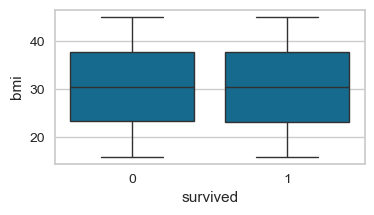

In [109]:
plt.figure(figsize=(4,2))
sns.boxplot(x='survived', y='bmi', data=df);
plt.show()

In [110]:
print(df.groupby('survived')['bmi'].describe())

             count       mean       std   min   25%   50%   75%   max
survived                                                             
0         693996.0  30.494141  8.368874  16.0  23.3  30.5  37.7  45.0
1         196004.0  30.494278  8.367376  16.0  23.2  30.5  37.7  45.0


In [111]:
group0 = df[df["survived"] == 0]['bmi'].dropna()
group1 = df[df["survived"] == 1]['bmi'].dropna()

bivar_bmi_results = pd.DataFrame(cont_tests(group0, group1))
print(bivar_bmi_results)

         variable  group0_mean  group1_mean  t-test_p    mw_p   cohen_d
0  treatment_type    30.494141    30.494278  0.994904  0.9943  0.000016


**Cholesterol vs Survived**

Again, there is minimal difference between the means/medians of cholesterol levels (233.63, 242), the spread (std=43), and the quartiles (between 196-271 mg/dL) in regard to suviving. While both survivors and non suvivors had elevated levels of cholesterol but cholesterol levels alone will not determine survival outcomes in the dataset. 

In the statistical tests below, the mean cholesterol differs by around ~0.016 points (nothing meaningful), the t-test p=0.882 and mann-whitney u test p= 0.923 (both >0.05) show no statistically different difference, and once again the cohen's d= 0.0004 shows no effect. Again, it is proven cholesterol has no relationship to survival in this dataset. 


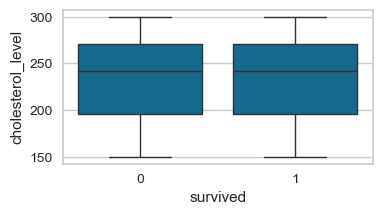

In [112]:
plt.figure(figsize=(4,2))
sns.boxplot(x='survived', y='cholesterol_level', data=df);
plt.show()

In [113]:
print(df.groupby('survived')['cholesterol_level'].describe())

             count        mean        std    min    25%    50%    75%    max
survived                                                                    
0         693996.0  233.630285  43.434564  150.0  196.0  242.0  271.0  300.0
1         196004.0  233.646773  43.424290  150.0  196.0  242.0  271.0  300.0


In [114]:
group0 = df[df["survived"] == 0]['cholesterol_level'].dropna()
group1 = df[df["survived"] == 1]['cholesterol_level'].dropna()

bivar_chol_results = pd.DataFrame(cont_tests(group0, group1))
print(bivar_chol_results)

         variable  group0_mean  group1_mean  t-test_p      mw_p  cohen_d
0  treatment_type   233.630285   233.646773  0.882018  0.923347  0.00038


#### 3.3.2 Binary vs Target

**Here we are asking if survival rates differ between different groups**

To analyze any influence from the binary variables on the target feature, we will be 
- Computing survival rates for each group 0/1
- Adding confidence intervals to show uncertainity. 
- Performing the statistical test, Chi-squared test


**Gender vs Survival**

The differences between gender and survival (21.99-22.05% between male/female) indicates there is minimal influence of gender on survival. The p value is > 0.05 so this indicates that this feature does not show a statistically significant assosication with survival in this dataset. 

**Family History vs Survival**

Again, there is little difference having or not between a family history of cancer and survival (21.9-22.07%) and the p value being >0.05 shows us no statistically significant assosication with survival in this dataset. 

**Hypertension vs Survival**

There is no difference between having or not hypertension on survival (22.2%), and with a p value of =.958 (>0.05), we can conclude there is no statistically significant assosication with survival and hypertension in this dataset.

**Asthma vs Survival**

There is still minimal differences between having or not having asthma on survival rate (21.94-22.02%) and while the p value is closer to 0.05, it is still p=0.088, high enough to indicate no statistically significant assosication with survival and asthma in this dataset. 

**Cirrhosis vs Survival**

There is minimal different between having/not having cirrhosis and survival (21.98-22.17%), with the p value still >0.05 (0.066) showing us, once again, no statistically significant assosication with survival in this dataset. 


**Other Cancer vs Survival**

There is minimal different between having/not having another type of cancer diagnosis and survival (21.76-22.05%), with the p value still >0.05 (0.064), indicating no statistically significant assosication between survival and other cancer dianosis in this dataset. 


**OVERALL**
None of the binary variables are showing much influence on survival rates, indicating we should be focusing either more on continous variables (BMI/cholesterol), treatment types, or potential combinations of features/interactions between variables. 


['gender', 'family_history', 'hypertension', 'asthma', 'cirrhosis', 'other_cancer']
gender survival rates (%):
gender
0    21.991341
1    22.054482
Name: survived, dtype: float64
gender: p-value = 0.4739

family_history survival rates (%):
family_history
0    21.968143
1    22.077744
Name: survived, dtype: float64
family_history: p-value = 0.2131

hypertension survival rates (%):
hypertension
0    22.018707
1    22.024326
Name: survived, dtype: float64
hypertension: p-value = 0.9582

asthma survival rates (%):
asthma
0    22.093484
1    21.943268
Name: survived, dtype: float64
asthma: p-value = 0.0884

cirrhosis survival rates (%):
cirrhosis
0    21.979129
1    22.172938
Name: survived, dtype: float64
cirrhosis: p-value = 0.0655

other_cancer survival rates (%):
other_cancer
0    22.048328
1    21.760133
Name: survived, dtype: float64
other_cancer: p-value = 0.0635



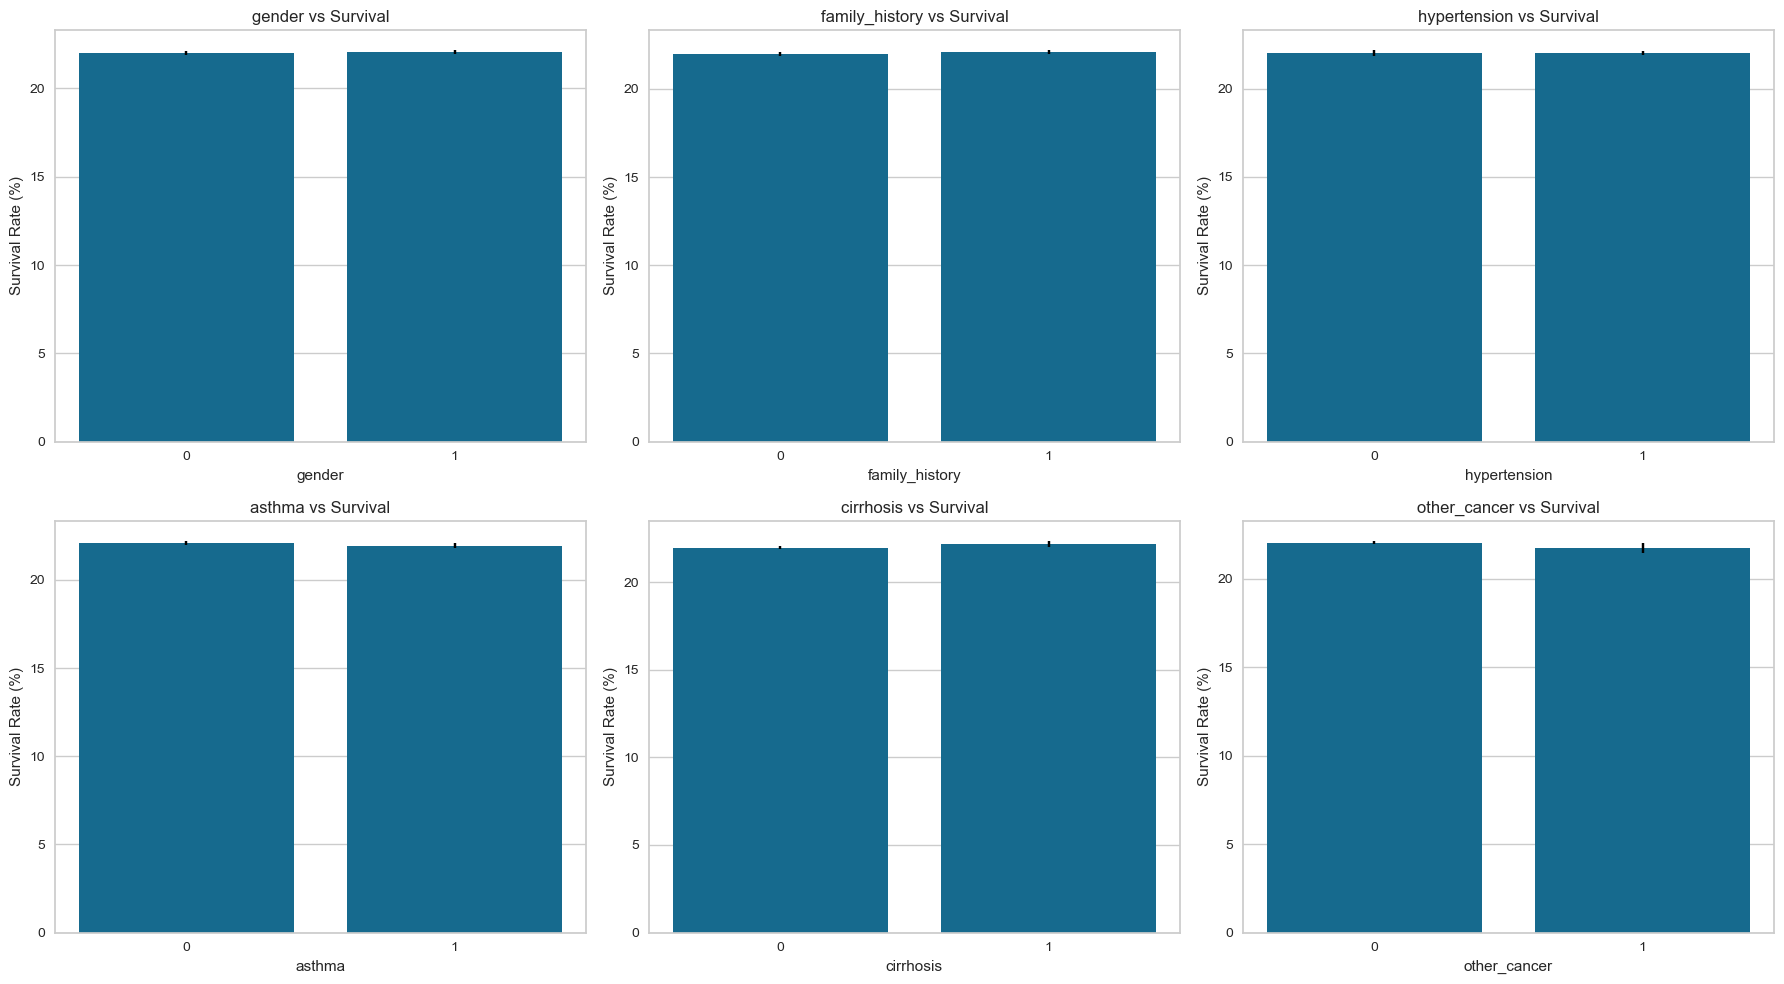

In [ ]:
binary_cols_1 = [col for col in binary_cols if col != "survived"]
print(binary_cols_1)      #Exclude 'survived' (would compare against itself)


for col in binary_cols_1:
    rates = df.groupby(col)['survived'].mean() * 100    #
    print(f"{col} survival rates (%):\n{rates}")      

    table = pd.crosstab(df[col], df['survived'])    #builds contingency table
    chi2, p, dof, ex = chi2_contingency(table)       #chi squared test - p values
    print(f"{col}: p-value = {p:.4f}\n")


#prints graphs to confirm our insights above: these binary features have minimal influence on survival rates

results = []
for col in binary_cols_1:
    grouped = df.groupby(col)["survived"].agg(['mean','count','sum'])  
    
    #add confidence intervals to show uncertainity around our estimate 
    for val, row in grouped.iterrows():
        ci_low, ci_high = proportion_confint(count=row['sum'], nobs=row['count'], method='wilson')
        
        results.append({
            "feature": col,     
            "group": val,
            "survival_rate":row['mean']* 100,
            "ci_low": ci_low* 100,
            "ci_high": ci_high*100    
        })    


binary_plot_df = pd.DataFrame(results)    #temporary df for analyzing these results
fig, axes = plt.subplots(2,3, figsize=(18,10))  
# fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
axes = axes.flatten()


for i, feature in enumerate(binary_cols_1):
    sub = binary_plot_df[binary_plot_df['feature'] == feature]
    sns.barplot(x="group", y="survival_rate", data=sub, ax=axes[i])
    
    #adds error bars: 
    axes[i].errorbar(x=np.arange(len(sub)), y=sub['survival_rate'],
                     yerr=[sub['survival_rate']- sub['ci_low'], sub['ci_high']-sub['survival_rate']],
                     fmt='none', c='black', capsize=5);
    
    axes[i].set_title(f"{feature} vs Survival"),
    axes[i].set_ylabel("Survival Rate (%)");
    axes[i].set_xlabel(feature);

plt.tight_layout()
plt.show();  



#### 3.3.3 Categorical vs Target

**Here we are asking if survival rates differ between different groups**

To analyze any influence from the categorical variables on the target feature, we will
- Calculate survival rates per category 
- Add confidence intervals to determine uncertainity 
- Visualize the differences 
- Perform the statistical test, chi-squared test of independence 

**Smoking Status vs Survival**

In the calculated survival rates per category, they are all almost equal, within 21.96-22.09%, showing tiny differences in survival rates. The chi squared p value = 0.772 (>0.05) shows no significant differences in survival across smoking status. The graphs done below confirm this to us. 

Smoker Status Summary:
0    0.220340
1    0.219641
2    0.220910
3    0.220025
Name: survival_rate, dtype: float64


Smoking status vs survival: p=0.7722926422184736


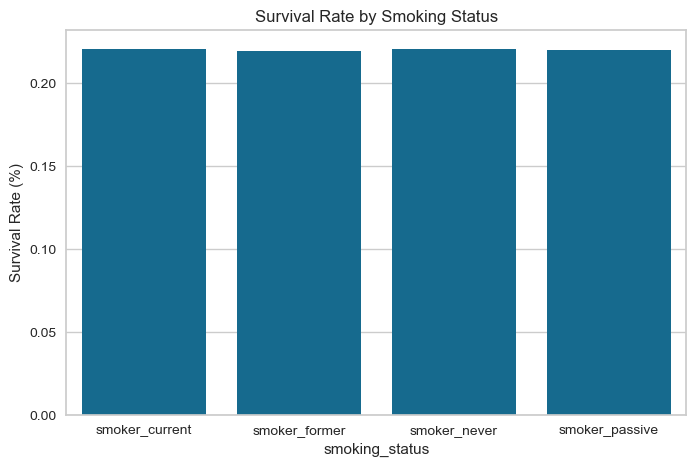

In [ ]:
smoking_cols = [c for c in df.columns if "smoker_" in c]
df["smoking_status"] = df[smoking_cols].idxmax(axis=1).str.replace("smoking_status_", "")
smoking_summary = df.groupby("smoking_status")["survived"].agg(survival_rate="mean",count="count", survivors="sum").reset_index() 

pd.crosstab(df["smoking_status"], df["survived"])
chi2, p, dof, ex = chi2_contingency(pd.crosstab(df["smoking_status"], df["survived"]))    #chi squared tets of independence 

print(f"Smoker Status Summary:\n{smoking_summary['survival_rate']}\n\n")
print(f"Smoking status vs survival: p={p}")


plt.figure(figsize=(8,5))
sns.barplot(
    x="smoking_status", y="survival_rate", 
    data=smoking_summary, 
    errorbar=('ci', 95)               #automatically computes 95% confidence intervals
)
plt.ylabel("Survival Rate (%)")
plt.title("Survival Rate by Smoking Status")
plt.show();

**Treatment Type vs Survival**

In the survival rates between treatment types, they range between 21.87-22.15%, with an almost equal value for each category. The chi-squared p value = 0.162 (>0.05) also shows no statisical difference between different types of treatment and survival (chemo/radiation/surgery/none). The graphs once again confirm this.


Treatment Type Summary:
0    0.218739
1    0.220126
2    0.220557
3    0.221499
Name: survival_rate, dtype: float64


Treatment type vs survival: p=0.1621055798959168


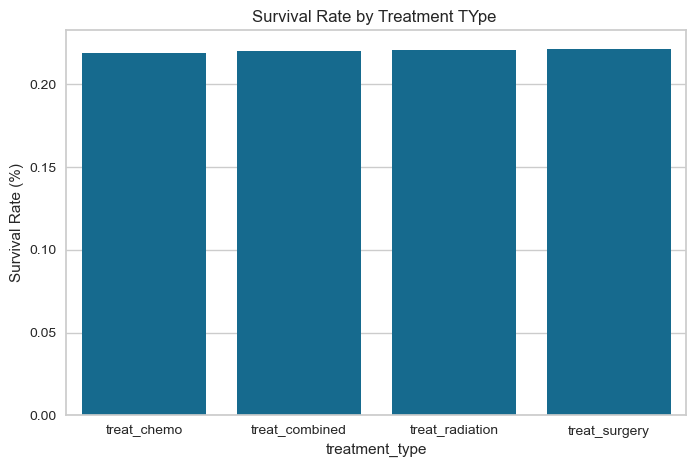

In [ ]:
treatment_cols = [c for c in df.columns if "treat_" in c]
df["treatment_type"] = df[treatment_cols].idxmax(axis=1).str.replace("treatment_type_", "")  


treatment_summary= df.groupby("treatment_type")["survived"].agg(survival_rate="mean", count="count", survivors="sum").reset_index()

pd.crosstab(df["treatment_type"], df["survived"])
chi2, p, dof, ex = chi2_contingency(pd.crosstab(df["treatment_type"], df["survived"]))

print(f"Treatment Type Summary:\n{treatment_summary['survival_rate']}\n\n")
print(f"Treatment type vs survival: p={p}")


plt.figure(figsize=(8,5))
sns.barplot(
    x="treatment_type", y="survival_rate", 
    data=treatment_summary, 
    errorbar=('ci', 95)               #automatically computes 95% confidence intervals
)
plt.ylabel("Survival Rate (%)")
plt.title("Survival Rate by Treatment TYpe ")
plt.show();


Considering that this is regarding treatment type and clearly receiving treatment or not is a huge factor in cancer survival. The reason this dataset is showing up little to no difference between treatment types is becausing this is considering survival to be 0/1, without the consideration of 
- length of survival after treatment type selected
- age, current health
- early/late stage diagnosis
- not all patients are eligable for each treatment (surgery would be for younger, healthier patients while late stage would be more likely to receieve chemotherapy). 

While this is good initial EDA, this should not discredit the influence treatment types or other variables with low statistical influence (up to this point). We need to consider more complex analysis. 

### 3.4 Multivariate Analysis

C:\Users\annap\AppData\Local\Temp\ipykernel_41752\168944054.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='Pastel2', linewidths=2);


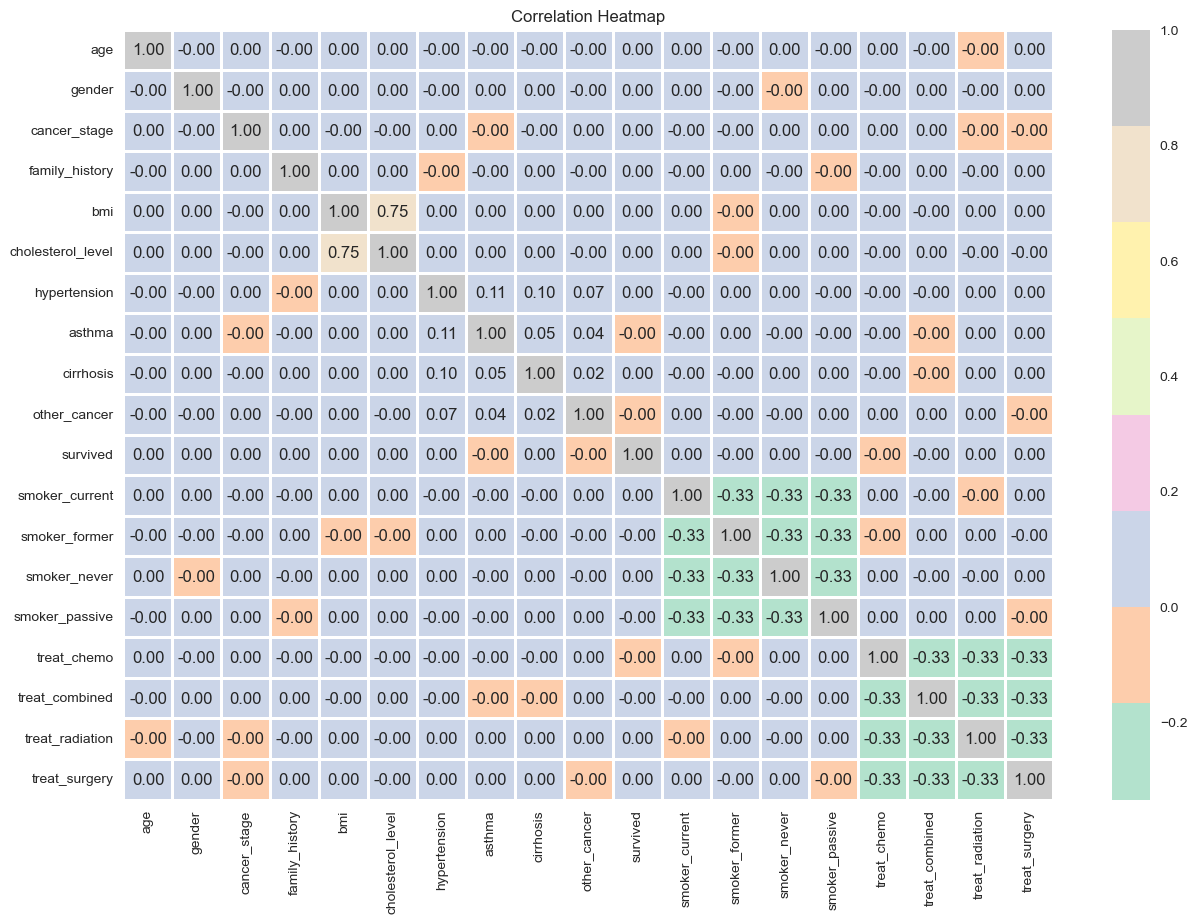

In [118]:
plt.figure(figsize=(15, 10))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='Pastel2', linewidths=2); 

plt.title('Correlation Heatmap')
plt.show()

In [ ]:
#visualizer = Rank2D(algorithm='pearson', size=(600, 500))
#visualizer.fit_transform(df)     #columns
#visualizer.poof()

### 3.5 Overall Takeaways

**After Univariate/Bivariate Analysis**

While the majority of these variables have little to no main influence over surivival rate, we should be considering a more depth exploration of their interactions. THIS IS NORMAL FOR MEDICAL DATASETS, ESPECIALLY WITH OUR IMBALANCE. 

Lets consider combining 
- cirrhosis, hypertension, asthma into "comorbidities" col
- convert smoking_status into "smoker" binary col
- keep treatment_type categorical 

Consider dropping 
- other_cancer  (as it is less than 10% of the dataset)
- country (there are 27 countries, all european - not incredibly important here)
- bmi (most of the data shows our patients are overweight to obese, no need to keep)
- diagnosis_date and end_treatment_date


We should consider interactions/combinations such as (not all though) to be more insightful 

- treatment_type, age
- treatment_type, comorbidities
- smoking_status, comorbidities
- BMI, comorbidities
- cholesterol_level, age/gender
- family_history, smoking_status
- comorbidities, treatment_type

**While we do have a decent amount of variables, we shouldn't drop any of them (unless absolutely necessary) as we would lose predictive power. We also do not have enough features to consider regularization, so we should leave it as is. 

We can consider FEATURE ENGINEERING instead (potential combinations above). 

We should also address our class imbalance before modeling as only 22% of our patients in the dataset survived, so we should either oversample or use class weighting when developing our model. 

## 4. Feature Engineering

Create new variables to combine 2+ existing features because univariate analysis can miss important relationships. after this, check correlation and drop any unnecessary features. 

**age x treatment_type**

**cholesterol_level x smoking_status**

**treatment_type x smokied**

**treatment_type x comorbidities**

**smoked x comorbidities**



### 4.1 Updated Cleaning and Schema Alignment

In [ ]:
df = df_raw.copy()
df = df.sample(frac=0.1, random_state=42)    #random sample of 40% of dataset

df.drop(["id", "bmi", "diagnosis_date", "end_treatment_date", "country", "other_cancer"], axis=1,inplace=True)   #not needed columns

# Standardize column names
df.columns = [c.strip().replace(" ", "_").replace("-", "_")
              for c in df.columns]

#combine columns for added simplicity 
df["comorbidities"] = ((df["hypertension"] ==1 )| (df["cirrhosis"] ==1 )| (df["asthma"] ==1 )).astype(int)
df.drop(["hypertension", "asthma", "cirrhosis"], axis=1, inplace=True)

df["smoked"] = ((df["smoking_status"] == "Current Smoker") | (df["smoking_status"] == "Former Smoker") | (df["smoking_status"] == "Passive Smoker"))
df.drop(["smoking_status"], axis=1, inplace=True)



num_cols = ["age", "cholesterol_level"]    #continuous cols
binary_cols = ['gender', 'family_history', 'comorbidities', 'smoked']    

for col in binary_cols:
    df[col] = to_binary(df[col])
    print(f"{col} done")


#ordinal encoding for cancer_stage
stage_map = {
    "Stage I": 1,
    "Stage II": 2,
    "Stage III": 3,
    "Stage IV": 4
}
df["cancer_stage"] = df["cancer_stage"].map(stage_map)

#one hot encoding - no other choice as they have no numerical order and frequency encoding wouldnt work (all about ~25% of dataset)
df = pd.get_dummies(df, columns=["treatment_type"], drop_first=False)

rename_dict = {
    'treatment_type_Chemotherapy': 'treat_chemo',
    'treatment_type_Combined': 'treat_combined',
    'treatment_type_Radiation': 'treat_radiation',
    'treatment_type_Surgery': 'treat_surgery'
}
df.rename(columns=rename_dict, inplace=True)

print(df.head(10))

gender done
family_history done
comorbidities done
smoked done
         age  gender  cancer_stage  family_history  cholesterol_level  \
773684  37.0       1             2               0                241   
278119  63.0       0             3               0                162   
810422  63.0       0             3               0                230   
443587  71.0       1             2               0                293   
701478  45.0       0             1               0                173   
100969  54.0       0             4               1                258   
774703  41.0       0             2               0                222   
684391  60.0       1             3               0                195   
612535  51.0       0             2               0                179   
59393   51.0       1             2               1                290   

        survived  comorbidities  smoked  treat_chemo  treat_combined  \
773684         0              0       1            0         

In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89000 entries, 773684 to 7266
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                89000 non-null  float64
 1   gender             89000 non-null  int32  
 2   cancer_stage       89000 non-null  int64  
 3   family_history     89000 non-null  int32  
 4   cholesterol_level  89000 non-null  int64  
 5   survived           89000 non-null  int64  
 6   comorbidities      89000 non-null  int32  
 7   smoked             89000 non-null  int32  
 8   treat_chemo        89000 non-null  uint8  
 9   treat_combined     89000 non-null  uint8  
 10  treat_radiation    89000 non-null  uint8  
 11  treat_surgery      89000 non-null  uint8  
dtypes: float64(1), int32(4), int64(3), uint8(4)
memory usage: 5.1 MB


### 4.2 Potential Interaction Terms

These are potential interaction terms, so we will test them in the next few 

In [122]:
#age x treatment_type as older patients could respond differently 
df["age_chemo"] = df["age"] * df["treat_chemo"]
df["age_surgery"] = df["age"] * df["treat_surgery"]     
df["age_combined"] = df["age"] * df["treat_combined"]
df["age_radiation"] = df["age"] * df["treat_radiation"]
df["age_stage"] = df["age"] * df["cancer_stage"]


#treatment x cancer_stage 
for t in ["treat_chemo", "treat_surgery", "treat_combined", "treat_radiation"]:
    df[f"{t}_stage"] = df[t] * df["cancer_stage"]   

#comorbidities x age as older patients matters more (less resilient)   
df["age_comorbid"] = df["age"]* df["comorbidities"]  
  
#comorbidities x treatment as this can change toleration to chemo/radiation
for t in ["treat_chemo","treat_surgery","treat_combined","treat_radiation"]:
    df[f"{t}_comorbid"] = df[t]*df["comorbidities"]   

#smoked x treatment_type as it could have differnt outcomes with chemo/radiation
for t in ["treat_chemo", "treat_surgery","treat_combined", "treat_radiation"]:
    df[f"{t}_smoked"] = df[t] * df["smoked"]



#### 4.2.1 Polynomial Features

To capture non-linear relationships, which is necessary for medical datasets - good for understanding trends/more complex patterns --> helps us better fit data & improves predictions

In [123]:
# generates poly features (age^2, cholesteorl^2)
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(df[num_cols])
poly_names = poly.get_feature_names_out(["age", "cholesterol_level"])  

df_poly = pd.DataFrame(poly_features, columns=poly_names, index=df.index)    #converts back to df
df = pd.concat([df, df_poly], axis=1)

print(df_poly.head())  
 

         age  cholesterol_level   age^2  age cholesterol_level  \
773684  37.0              241.0  1369.0                 8917.0   
278119  63.0              162.0  3969.0                10206.0   
810422  63.0              230.0  3969.0                14490.0   
443587  71.0              293.0  5041.0                20803.0   
701478  45.0              173.0  2025.0                 7785.0   

        cholesterol_level^2  
773684              58081.0  
278119              26244.0  
810422              52900.0  
443587              85849.0  
701478              29929.0  


In [124]:
df.head()

,age,gender,cancer_stage,family_history,cholesterol_level,survived,comorbidities,smoked,treat_chemo,treat_combined,...,treat_radiation_comorbid,treat_chemo_smoked,treat_surgery_smoked,treat_combined_smoked,treat_radiation_smoked,age,cholesterol_level,age^2,age cholesterol_level,cholesterol_level^2
773684,37.0,1,2,0,241,0,0,1,0,0,...,0,0,1,0,0,37.0,241.0,1369.0,8917.0,58081.0
278119,63.0,0,3,0,162,0,1,1,0,1,...,0,0,0,1,0,63.0,162.0,3969.0,10206.0,26244.0
810422,63.0,0,3,0,230,1,1,1,0,1,...,0,0,0,1,0,63.0,230.0,3969.0,14490.0,52900.0
443587,71.0,1,2,0,293,1,0,0,1,0,...,0,0,0,0,0,71.0,293.0,5041.0,20803.0,85849.0
701478,45.0,0,1,0,173,0,1,1,0,0,...,0,0,1,0,0,45.0,173.0,2025.0,7785.0,29929.0


### 4.3 Logistic Regression with L1 (Lasso)

In [125]:
target_col = "survived"
# num_cols = ["age", "bmi", "cholesterol_level"]    #continuous cols
# num_cols = df.shape[1]
# print(num_cols)
cat_like_binary_cols = binary_cols.copy()

X = df[num_cols + cat_like_binary_cols].copy()
X = df.drop(columns=["survived"])
X = X.loc[:, ~X.columns.duplicated()].copy()   
y = df[target_col].copy()

#makes sure we are constitent with X
num_cols = [c for c in ["age", "cholesterol_level"] if c in X.columns]
cat_like_binary_cols = [c for c in ['gender', 'family_history', 'comorbidities', 'smoked'] if c in X.columns]


# 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# Split temp into validation and test, 15% each overall
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=RANDOM_STATE
)
# Display shapes and class distributions as a DataFrame

info = {
    "Set": ["Train", "Validation", "Test", "Overall"],
    "X shape": [X_train.shape, X_val.shape, X_test.shape, X.shape],
    "y shape": [y_train.shape, y_val.shape, y_test.shape, y.shape],
    "p(survived=0)": [
        y_train.value_counts(normalize=True).get(0, 0.0),
        y_val.value_counts(normalize=True).get(0, 0.0),
        y_test.value_counts(normalize=True).get(0, 0.0),
        y.value_counts(normalize=True).get(0, 0.0),
    ],
    "p(survived=1)": [
        y_train.value_counts(normalize=True).get(1, 0.0),
        y_val.value_counts(normalize=True).get(1, 0.0),
        y_test.value_counts(normalize=True).get(1, 0.0),
        y.value_counts(normalize=True).get(1, 0.0),
    ],
}

df_info = pd.DataFrame(info)
display(df_info.style.format({"p(survived=0)": "{:.3f}", "p(survived=1)": "{:.3f}"}))



# Preprocessing
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=True, with_std=True))
])

binary_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("bin", binary_transformer, cat_like_binary_cols)
    ],
    remainder="passthrough",  # drop= drops any column not in previously specified, switched to keep engineered variables
    verbose_feature_names_out=False  # keeps original feature names
)



,Set,X shape,y shape,p(survived=0),p(survived=1)
0,Train,"(71200, 32)","(71200,)",0.780,0.220
1,Validation,"(13350, 32)","(13350,)",0.780,0.220
2,Test,"(4450, 32)","(4450,)",0.780,0.220
3,Overall,"(89000, 32)","(89000,)",0.780,0.220


In [129]:
lasso = LogisticRegression(penalty="l1", solver="liblinear", C=1, class_weight="balanced")


pipe = Pipeline(steps=[
    ("preprocess", preprocess),  
    ("lasso", lasso)  
])
pipe.fit(X_train, y_train)   


feature_names = pipe.named_steps["preprocess"].get_feature_names_out()  
coef = pd.Series(pipe.named_steps["lasso"].coef_.flatten(),index=feature_names)

print("\nNon zero features after l1 regulariztion")   
print(coef[coef != 0])    
# print("Chosen C:", pipe.named_steps["lasso"].C_)



Non zero features after l1 regulariztion
age                        -0.032281
cholesterol_level           0.112411
gender                      0.008103
family_history              0.015527
comorbidities              -0.183528
smoked                      0.009190
cancer_stage                0.026976
treat_chemo                 0.100379
treat_combined             -0.064858
treat_surgery               0.084670
age_chemo                   0.006225
age_surgery                 0.006912
age_combined                0.009215
age_radiation               0.009762
age_stage                  -0.000440
treat_chemo_stage          -0.007445
treat_surgery_stage         0.010905
treat_combined_stage        0.004454
age_comorbid                0.003761
treat_chemo_comorbid        0.022932
treat_surgery_comorbid     -0.019805
treat_radiation_comorbid   -0.057059
treat_chemo_smoked         -0.020528
treat_surgery_smoked        0.007441
treat_radiation_smoked      0.011035
age^2                      -0.000

c:\Users\annap\miniconda3\envs\od_rai_mamba\lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


**TakeAways**

These features should be kept, while getting rid of the features that shrank towards 0 (after chaning C=10 to C=1, we saw the effects of stronger regularization and we can now understand which features should be dropped). The coefficients are overall small, as our target feature is very imbalanced and none of the original features show significant influence on survival. L1 shrinks weaker/noisy features towards 0 and keeps the contributing features

Main Features (main predictors)
- age
- cholesterol_levels
- gender
- family_history
- comorbidities
- smoked
- cancer_stage 
- treatments (chemo, radiation, surgery, combined)
- Interaction terms w modererate effects (>0.01)
    - treat_chemo_comorbid  (0.022)
    - treat_surgery_comorbid (-0.019)
    - treat_radiation_comorbid (-0.057)
    - treat_chemo_smoked (-0.02)
    - treat_radiation_smoked (0.011)

Features to Drop (<0.01)
- polynomial terms
- age_stage
- age_chemo, age_surgery, age_combined, age_radiation
- treat_combined_stage, age_comorbid




## 5. Feature Selection

We extend the analysis with univariate tests and model-based importance to identify a compact, informative feature set. We'll:
- Evaluate binary-like features vs `survived` using chi-squared tests.
- Refit the L1-logistic model and rank features by absolute coefficient magnitude.
- Combine statistically significant and model-important features into `best_features`.


In [ ]:
#Univariate chi-squared tests for binary-like features
binary_like_cols = [c for c in df.columns if c in ['gender','family_history','comorbidities','smoked']]

uni_rows = []
for c in binary_like_cols:
    ct = pd.crosstab(df[c], df['survived'])
    if ct.shape[0] >= 2 and ct.shape[1] >= 2:
        _, p, _, _ = chi2_contingency(ct)
        uni_rows.append({'feature': c, 'test': 'chi2', 'p_value': p})

univariate_results = pd.DataFrame(uni_rows).sort_values('p_value')
display(univariate_results)

#Model-based feature importance via L1 coefficients (reuse previous pipeline or rebuild)
#Ensureing X, y, preprocess are available from earlier sections
if 'pipe' in globals():
    #refit on full training set used earlier if available
    pipe_refit = clone(pipe)
    pipe_refit.fit(X_train, y_train)
    feature_names_refit = pipe_refit.named_steps['preprocess'].get_feature_names_out()
    coef_refit = pd.Series(pipe_refit.named_steps['lasso'].coef_.flatten(), index=feature_names_refit)
else:
    lasso_fs = LogisticRegression(penalty='l1', solver='liblinear', C=1, class_weight='balanced', random_state=RANDOM_STATE)
    pipe_refit = Pipeline(steps=[('preprocess', preprocess), ('lasso', lasso_fs)])
    pipe_refit.fit(X_train, y_train)
    feature_names_refit = pipe_refit.named_steps['preprocess'].get_feature_names_out()
    coef_refit = pd.Series(pipe_refit.named_steps['lasso'].coef_.flatten(), index=feature_names_refit)

importance_df = (
    pd.DataFrame({'feature': coef_refit.index, 'abs_coef': coef_refit.abs().values})
      .sort_values('abs_coef', ascending=False)
)
display(importance_df.head(20))

#combine statistically significant and model-important features
alpha = 0.05
significant_features = [r['feature'] for _, r in univariate_results.iterrows() if r['p_value'] < alpha]
model_top_n = 20
model_important = importance_df['feature'].head(model_top_n).tolist()

best_features = sorted(set(significant_features + model_important))
print('Selected best_features (top union):', best_features)


## 6. Model Validation and Performance

We validate the selected features using cross-validation on the L1-logistic model. We report ROC AUC, Average Precision (PR AUC), Brier score, log loss, and F1, and visualize calibration.


In [ ]:
#Build final pipeline restricted to best_features (if there)
selected_columns = [c for c in best_features if c in X.columns]
if not selected_columns:
    selected_columns = X.columns.tolist()

preprocess_final = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, [c for c in num_cols if c in selected_columns]),
        ('bin', binary_transformer, [c for c in cat_like_binary_cols if c in selected_columns])
    ],
    remainder='drop',
    verbose_feature_names_out=False
)

pipe_final = Pipeline(steps=[
    ('preprocess', preprocess_final),
    ('lasso', LogisticRegression(penalty='l1', solver='liblinear', C=1, class_weight='balanced', random_state=RANDOM_STATE))
])

pipe_final.fit(X_train[selected_columns], y_train)

#Evaluating on validation and test
for split_name, XX, yy in [('Validation', X_val, y_val), ('Test', X_test, y_test)]:
    XXs = XX[selected_columns]
    y_proba = pipe_final.predict_proba(XXs)[:, 1]
    y_pred = pipe_final.predict(XXs)
    metrics = {
        'roc_auc': roc_auc_score(yy, y_proba),
        'avg_precision': average_precision_score(yy, y_proba),
        'brier': brier_score_loss(yy, y_proba),
        'log_loss': log_loss(yy, y_proba),
        'f1': f1_score(yy, y_pred)
    }
    print(split_name, metrics)

#Calibration curve on the test set
CalibrationDisplay.from_estimator(pipe_final, X_test[selected_columns], y_test, n_bins=10)
plt.show()


## 7. Model Interpretability and Fairness Analysis

We add SHAP-based explanations on a subsample and a simple fairness check with group-disaggregated metrics (if `fairlearn` is available).


In [ ]:
#SHAP interpretability
try:
    import shap
    SHAP_AVAILABLE = True
except Exception:
    SHAP_AVAILABLE = False

if SHAP_AVAILABLE:
    shap_sample_size = min(1000, len(X_test))
    #Limit to selected columns present in the final pipeline
    X_shap = X_test[selected_columns].sample(n=shap_sample_size, random_state=RANDOM_STATE)

    #KernelExplainer for black-box pipeline
    try:
        explainer = shap.Explainer(pipe_final.predict_proba, X_shap)
        shap_values = explainer(X_shap)

        plt.figure(figsize=(10, 6))
        shap.summary_plot(shap_values[...,1], X_shap, plot_type='bar', show=False)
        plt.title('SHAP Feature Importance (Mean |SHAP value|)')
        plt.tight_layout()
        plt.show()

        #waterfall for a few examples
        print('\nSHAP Waterfall Plots for Sample Predictions:')
        for i in range(min(3, len(X_shap))):
            shap.plots.waterfall(shap_values[i, ..., 1], show=False)
            plt.title(f'SHAP Waterfall - Sample {i+1}')
            plt.tight_layout()
            plt.show()
    except Exception as e:
        print('SHAP computation skipped due to error:', e)
else:
    print('SHAP not available; skipping interpretability plots.')

#Fairness metrics (if fairlearn available)
if _FAIRLEARN:
    try:
        mf = MetricFrame(
            metrics={
                'selection_rate': selection_rate,
                'tpr': true_positive_rate,
                'fpr': false_positive_rate,
            },
            y_true=y_test,
            y_pred=pipe_final.predict(X_test[selected_columns]),
            sensitive_features=X_test['gender'] if 'gender' in X_test.columns else None
        )
        print('Group metrics by gender (if available):')
        display(mf.by_group)
    except Exception as e:
        print('Fairness analysis skipped due to error:', e)
else:
    print('fairlearn not available; skipping fairness analysis.')
